# 売買シミュレーションに備えた実験
- いちごの流通期間は 2~3日
- 10日後の価格を予測することで、予測日から流通期間を引いた7日間から販売日を決定可能に

In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import japanize_matplotlib

In [197]:
def root_mean_squared_error(y_pred, y_test):
    return mean_squared_error(y_pred, y_test)**(1/2)

In [198]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()


In [199]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]


In [200]:
# 日にちの処理
# timestamp型 → timedelta
# date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-" +
        str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
# df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
df = df.drop("date", axis=1).copy()


In [201]:
# 特異日 (天皇即位)
outlier = df[df["価格"].max() == df["価格"]].index 
# df = df.drop(outlier, axis=0).copy()

In [202]:
# 数量で重み付け
def ma_weighted(price, df):
    """
    Args:
        price (df.rolling): df.rolling.apply()を想定した価格列
        df: 重み列を取るための元df
    return:
        ma_w = 数量加重移動平均
    """

    df_price = df.loc[price.index, '価格']
    df_num = df.loc[price.index, '数量']
    
    ma_w = 0
    for p, n in zip(df_price, df_num):
        ma_w += n * p/df_num.sum()

    return ma_w


In [203]:
ma_w3 = df["価格"].rolling(3).apply(ma_weighted, args=(df,), raw=False)
ma_w5 = df["価格"].rolling(5).apply(ma_weighted, args=(df,), raw=False)
ma_w7 = df["価格"].rolling(7).apply(ma_weighted, args=(df,), raw=False)


In [204]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
ma_w5 = ma_w5.dropna()
df_train = ma_w5[ma_w5.index < 9426].copy()
df_test = ma_w5[ma_w5.index >= 9426].copy()


In [205]:
date_train_raw = df.loc[df_train.index, ["年", "月", "日", "曜日"]].copy()
date_test_raw = df.loc[df_test.index, ["年", "月", "日", "曜日"]].copy()

In [206]:
# 学習データ作成
span = 10
n_train = df_train.shape[0] - span - 6
X_train_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_train)]
y_train_idx = [i + span + 6 for i in range(n_train)]

date_train_idx = [i + 6 for i in range(n_train)]

n_test = df_test.shape[0] - span - 6
X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
y_test_idx = [i + span + 6 for i in range(n_test)]

date_test_idx = [i + 6 for i in range(n_test)]

X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

In [207]:
X_train_idx

[array([0, 1, 2, 3, 4, 5, 6]),
 array([1, 2, 3, 4, 5, 6, 7]),
 array([2, 3, 4, 5, 6, 7, 8]),
 array([3, 4, 5, 6, 7, 8, 9]),
 array([ 4,  5,  6,  7,  8,  9, 10]),
 array([ 5,  6,  7,  8,  9, 10, 11]),
 array([ 6,  7,  8,  9, 10, 11, 12]),
 array([ 7,  8,  9, 10, 11, 12, 13]),
 array([ 8,  9, 10, 11, 12, 13, 14]),
 array([ 9, 10, 11, 12, 13, 14, 15]),
 array([10, 11, 12, 13, 14, 15, 16]),
 array([11, 12, 13, 14, 15, 16, 17]),
 array([12, 13, 14, 15, 16, 17, 18]),
 array([13, 14, 15, 16, 17, 18, 19]),
 array([14, 15, 16, 17, 18, 19, 20]),
 array([15, 16, 17, 18, 19, 20, 21]),
 array([16, 17, 18, 19, 20, 21, 22]),
 array([17, 18, 19, 20, 21, 22, 23]),
 array([18, 19, 20, 21, 22, 23, 24]),
 array([19, 20, 21, 22, 23, 24, 25]),
 array([20, 21, 22, 23, 24, 25, 26]),
 array([21, 22, 23, 24, 25, 26, 27]),
 array([22, 23, 24, 25, 26, 27, 28]),
 array([23, 24, 25, 26, 27, 28, 29]),
 array([24, 25, 26, 27, 28, 29, 30]),
 array([25, 26, 27, 28, 29, 30, 31]),
 array([26, 27, 28, 29, 30, 31, 32]),
 a

In [208]:
y_train_idx

[16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196

In [209]:
X_train = pd.DataFrame(X_train, columns=np.arange(7))
X_test = pd.DataFrame(X_test, columns=np.arange(7))
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [210]:
date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

In [211]:
X_train = pd.concat([X_train, date_train], axis=1)
X_test = pd.concat([X_test, date_test], axis=1)

In [212]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(mape)

208.60556557978728
0.06955631357819869


Text(0.5, 1.0, '市場価格5日移動平均の予測')

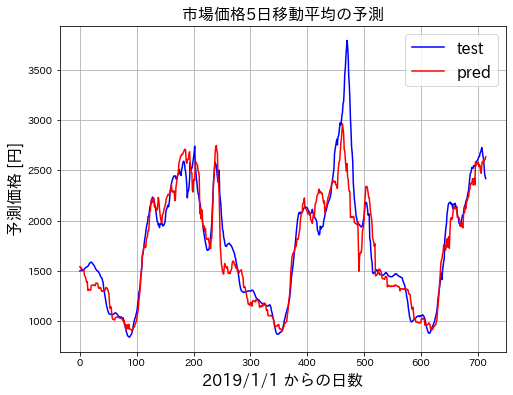

In [213]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格5日移動平均の予測", fontsize=16)

In [214]:
test_year_index = df[df["年"] >= 2019].index

In [215]:
year2020_index_temp = df[df["年"] == 2020].index

In [216]:
year2020_index = np.arange(list(test_year_index).index(year2020_index_temp[0]),list(test_year_index).index(year2020_index_temp[-1]))

## 2020年に関して

In [217]:
y_test_temp = y_test.copy()
y_pred_temp = y_pred.copy()
y_test = y_test[year2020_index]
y_pred = y_pred[year2020_index]

Text(0.5, 1.0, '市場価格5日移動平均の予測')

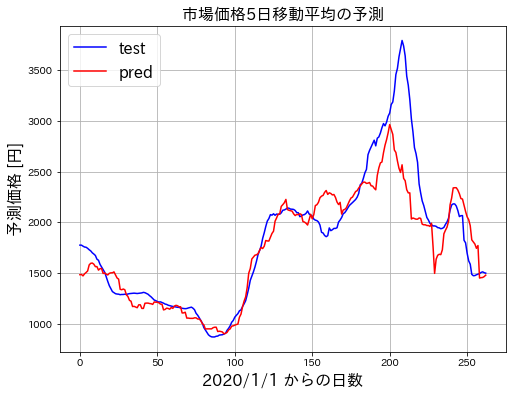

In [218]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2020/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格5日移動平均の予測", fontsize=16)

In [219]:
y_test = y_test_temp.copy()
y_pred = y_pred_temp.copy()

### 考察
- 概形は確かに一致
- 予測結果の振動がいまだに存在
- ピーク付近での振動は特に激しい

## 週ごとの分析
- 50日ごとにプロット
- [[0~7], [50~57], ...]

In [220]:
week_days = np.arange(50)
start_days = np.arange(5) * 50

In [221]:
y_test_temp = y_test.copy()
y_pred_temp = y_pred.copy()
y_test = y_test[year2020_index]
y_pred = y_pred[year2020_index]

In [222]:
plot_list = np.array([week_days + sd for sd in start_days])

In [223]:
plot_list[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [224]:
y_test

262    1775.199792
263    1775.189556
264    1765.139818
265    1756.720176
266    1754.377367
          ...     
520    1495.269286
521    1506.134888
522    1512.199520
523    1504.227330
524    1499.222860
Length: 263, dtype: float64

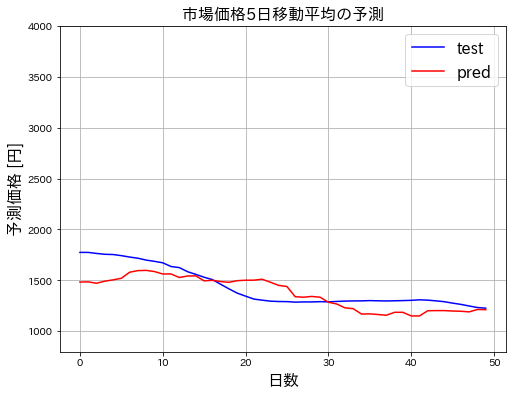

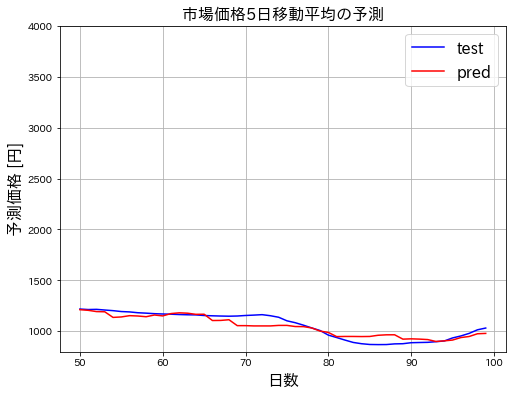

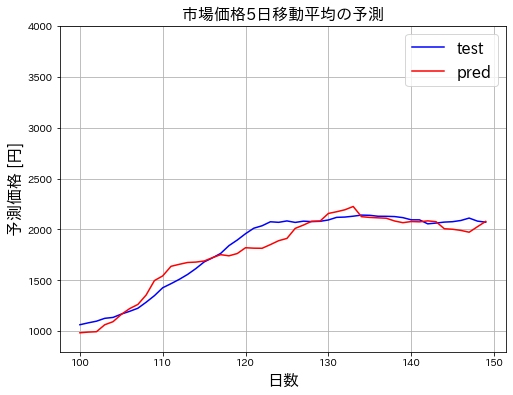

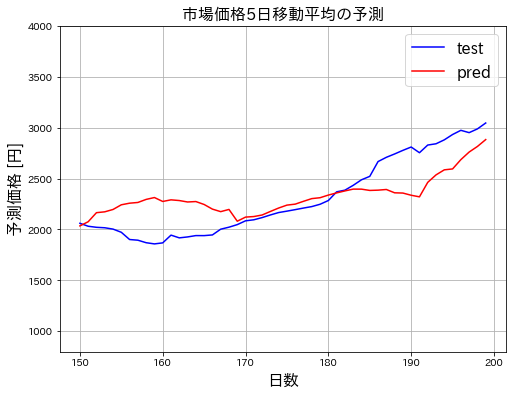

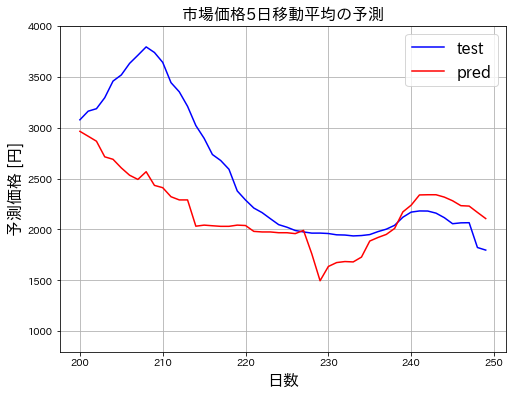

In [225]:
for pl in plot_list:
    fig, ax = plt.subplots()
    ax.grid()
    fig.set_figwidth(8)
    fig.set_figheight(6)

    ax.plot(pl, y_test.iloc[pl], "b", label="test")
    ax.plot(pl, y_pred[pl], "r", label="pred")
    ax.legend(fontsize=16)
    ax.set_xlabel("日数", fontsize=16)
    ax.set_ylabel("予測価格 [円]", fontsize=16)
    ax.set_title("市場価格5日移動平均の予測", fontsize=16)

    ax.set_ylim([800,4000])

In [226]:
y_diff = y_test - y_pred

In [227]:
y_diff.mean()

69.9983680361085

低めに予測している傾向があることがわかる

Text(0, 0.5, '市場価格 - 予測価格 [円]')

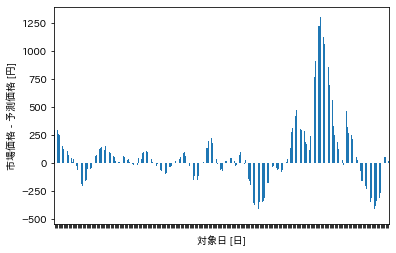

In [228]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
y_diff.plot(ax=ax, kind="bar")
ax.set_xticklabels([])
ax.set_xlabel("対象日 [日]")
ax.set_ylabel("市場価格 - 予測価格 [円]")

- 正：売っていれば得だが売らない可能性が高くなる → 損
- 誤：差額 = 損

# どんな時に損？
- 市場価格が高い日が周辺の予測価格より低い予測になっている場合（市場価格が高い日の市場価格 - 予測価格最大の日の市場価格）
- 予測価格が市場価格より高い場合（差額＝損失）

→ 概形があっていれば(最大最小が一致)低めに予測してもok
- 50日単位では大幅な損失は出ない
- 10日単位で最大値の予測を可能としているかは微妙

→ 高めに予測するのはまずい、年間最大値の直前でその傾向が見られる（許容範囲？）

→ 最大値の週でピークだけでも合わせられると更によくなりそうではある

# 7 日分の予測

In [229]:
# 学習データ作成
# data = [4日後予測訓練データ, 5日後予測訓練データ, ..., 10日後予測訓練データ]

span = 10
data = []
for sp in range(4,11):
    n_train = df_train.shape[0] - sp - 6
    X_train_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_train)]
    y_train_idx = [i + sp + 6 for i in range(n_train)]

    date_train_idx = [i + 6 for i in range(n_train)]

    n_test = df_test.shape[0] - sp - 6
    X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
    y_test_idx = [i + sp + 6 for i in range(n_test)]

    date_test_idx = [i + 6 for i in range(n_test)]

    X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

    y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

    X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
    y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

    X_train = pd.DataFrame(X_train, columns=np.arange(7))
    X_test = pd.DataFrame(X_test, columns=np.arange(7))
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)

    date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
    date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

    X_train = pd.concat([X_train, date_train], axis=1)
    X_test = pd.concat([X_test, date_test], axis=1)

    data.append((X_train, X_test, y_train, y_test))

In [230]:
# y_preds = [4日後予測データ, 5日後予測データ, ..., 10日後予測データ]

y_preds = []
for i in range(data.__len__()):
    X_train, X_test, y_train, y_test = data[i][0], data[i][1], data[i][2], data[i][3]

    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = root_mean_squared_error(y_pred, y_test)
    print(score)

    ape = sum(abs((y_test-y_pred)/y_test))
    mape = ape/y_test.shape[0]
    print(mape)

    y_preds.append(y_pred)

152.87335371530077
0.04265687606131471
167.42563249986372
0.04898505031284628
178.33708145843627
0.056432169833098976
187.275739116027
0.06050149909514425
192.52051982586158
0.06181689322490505
198.87448514492291
0.06552261407165835
208.60556557978728
0.06955631357819869


## 最大値と予測した日が実際に最大だった割合

In [231]:
# テストデータ数
for p in y_preds:
    print(p.__len__())

# テストデータ数を揃える
y_preds_fix = []
for p in y_preds:
    y_preds_fix.append(p[:715])


721
720
719
718
717
716
715


In [232]:
y_preds_fix = np.array(y_preds_fix).T

In [233]:
y_preds_max = [np.argmax(ypf) for ypf in y_preds_fix]

In [234]:
y_tests_fix = np.array([data[0][3][i:i+7].values for i in range(data[0][3].__len__()-6)])

In [235]:
y_tests_max = [np.argmax(ytf) for ytf in y_tests_fix]

In [236]:
y_preds_fix.shape, y_tests_fix.shape

((715, 7), (715, 7))

In [237]:
from sklearn.metrics import accuracy_score
accuracy_score(y_preds_max, y_tests_max)

0.4881118881118881

In [239]:
y_tests_max

[6,
 6,
 6,
 5,
 4,
 3,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 6,
 6,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 4,
 3,
 2,
 1,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 4,
 3,
 2,
 6,
 6,
 6,
 6,
 5,
 4,
 3,
 2,
 6,
 6,
 6,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 6,
 5,
 4,
 3,
 2,
 6,
 6,
 6,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 0,
 0,
 4,
 3,
 2,
